In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# from utils import query_connector

In [2]:
df = pd.read_csv('C:\\Users\\User\\PycharmProjects\\pums\\psam_h05.csv')
df.FS.value_counts()

FS
2.0    60584
1.0     6838
Name: count, dtype: int64

In [3]:
df = df[~df['FS'].isna()]

In [4]:
# 1. Define groups
income_fields = ["FINCP", "HINCP",]
housing_fields = ["ELEP", "CONP", "FULP", "GASP", "INSP", "MHP", "MRGP", "RNTP", "SMP", 
                  "WATP", "GRNTP", "SMOCP", "TAXAMT", "CONP",]
# 2. Adjust to 2022 dollars
for field in income_fields:
    df[f"{field}"] = df[field] * df["ADJINC"] / 1_000_000

for field in housing_fields:
    df[f"{field}"] = df[field] * df["ADJHSG"] / 1_000_000


# Derived ratios
df["income_per_person"] = df["HINCP"] / (df["NP"].replace(0, np.nan))
df["income_per_room"] = df["HINCP"] / (df["RMSP"].replace(0, np.nan))
df["rent_to_income_ratio"] = df["RNTP"] / (df["HINCP"].replace(0, np.nan))

# Create binary target
df["FS"] = df["FS"].map({1: 1, 2: 0})

# 6. Count imputed features
alloc_cols = [col for col in df.columns if col.startswith("F") and col.endswith("P")]
df["num_imputed_features"] = df[alloc_cols].eq(1).sum(axis=1)

In [5]:
categorical_cols = [
    "YRBLT", 
    "HHT",           # Household/family type
    "HHL",           # Household language
    "WORKSTAT",      # Work status
    # "WKEXREL",       # Work experience of family
    "HHLDRRAC1P",    # Race of householder
    # "HHLDRHISP",     # Hispanic origin of householder
    # "CPLT",          # Relationship type
    "HHT2",          # Additional household structure
]

# Fill NaN in categorical columns to avoid errors
df[categorical_cols] = df[categorical_cols].fillna("Unknown")

# One-hot encode
df = pd.get_dummies(df, columns=categorical_cols, drop_first=False, dtype=int)

In [6]:
def map_cplt(val):
    if val in [1, 2]:
        return "Spouse_Household"
    elif val in [3, 4]:
        return "Partner_Household"
    else:
        return "Not_Couple"

df["CPLT_group"] = df["CPLT"].replace("b", np.nan).astype(float).apply(map_cplt)


def map_wkexrel(val):
    if val in [1, 2, 4, 5]:
        return "Both_Worked"
    elif val in [3, 6]:
        return "Householder_Worked_Only"
    elif val in [7, 8]:
        return "Spouse_Worked_Only"
    elif val == 9:
        return "Neither_Worked"
    elif val in [10, 13]:
        return "Householder_Alone_FT"
    elif val in [11, 14]:
        return "Householder_Alone_Part"
    elif val in [12, 15]:
        return "Householder_Alone_None"
    else:
        return "No_Family"


df["WKEXREL_group"] = df["WKEXREL"].replace("bb", np.nan).apply(map_wkexrel)

df = pd.get_dummies(df, columns=["CPLT_group", "WKEXREL_group"], dtype=int)

df.drop(columns=["CPLT", "WKEXREL"], inplace=True)

In [7]:
# 1. Household Composition
df["is_single_person"] = (df["NP"] == 1).astype(int)
df["is_large_household"] = (df["NP"] >= 5).astype(int)
df["room_per_person"] = df["RMSP"] / df["NP"].replace(0, np.nan)
df["bathroom_to_bedroom_ratio"] = df["FBATHP"] / df["BDSP"].replace(0, np.nan)

# 2. Affordability Indicators
df["housing_cost_ratio"] = (
    df["GRNTP"].fillna(df["SMOCP"]).fillna(df["RNTP"]) / df["HINCP"].replace(0, np.nan)
)
df["mortgage_or_rent_flag"] = ((df["MRGP"] > 0) | (df["RNTP"] > 0)).astype(int)
df["owns_home_flag"] = df["TEN"].isin([1, 2]).astype(int)

# 3. Technology Access
df["has_internet"] = (df["HISPEED"] == 1).astype(int)
df["num_devices"] = df[["SMARTPHONE", "TABLET", "LAPTOP"]].eq(1).sum(axis=1)
df["tech_deprived_flag"] = ((df["num_devices"] == 0) & (df["has_internet"] == 0)).astype(int)

# 4. Transportation
df["no_vehicle_flag"] = (df["VEH"] == 0).astype(int)

# 5. Top-coded Property Flag
df["valp_topcoded"] = (df["VALP"] >= 1000000).astype(int)  # You can adjust threshold
df["Is_Hispanic"] = df["HHLDRHISP"].map({1: 1, 2: 0})

# 6. Missingness / Imputation
alloc_cols = [col for col in df.columns if col.startswith("F") and col.endswith("P")]
df["num_imputed_features"] = df[alloc_cols].eq(1).sum(axis=1)
df["any_imputed_flag"] = (df["num_imputed_features"] > 0).astype(int)

# 7. Property Value Buckets
df["VALP_bucket"] = pd.cut(
    df["VALP"],
    bins=[-1, 100000, 300000, np.inf],
    labels=["low", "mid", "high"]
)
df = pd.get_dummies(df, columns=["VALP_bucket"], prefix="VALP", dtype=int)
df.drop(columns=["VALP"], inplace=True)

# 8. Combine Room + Household Size into Crowding Score
df["crowding_score"] = df["NP"] / df["RMSP"].replace(0, np.nan)
df["is_crowded"] = (df["crowding_score"] > 1).astype(int)

# 9. Utility burden
df["num_utilities_paid"] = df[["WATP", "ELEP", "GASP", "INSP"]].gt(0).sum(axis=1)
df["pays_all_utilities"] = (df["num_utilities_paid"] == 4).astype(int)

# 10. Age group
df["age_group"] = pd.cut(
    df["HHLDRAGEP"],
    bins=[0, 30, 45, 60, 75, 120],
    labels=["young", "mid_young", "middle", "senior", "elderly"]
)

df = pd.get_dummies(df, columns=["age_group"], prefix="age")

In [8]:
df["age_x_income"] = df["HHLDRAGEP"] * df["HINCP"]
df["np_x_room"] = df["NP"] * df["RMSP"]
df["rentburden_x_tenure"] = df["rent_to_income_ratio"] * df["TEN"]

df.drop(columns=["HHLDRAGEP"], inplace=True)

In [9]:
# Define features, excluding FS (target), RT, SERIALNO, and WGTP
excluded = ['FS', 'RT', 'SERIALNO', 'ADJINC', 'ADJHSG'] + ['WGPT' + str(i) for i in range(1, 81, 1)]
features = [col for col in df.columns if col not in excluded]
X = df[features]
y = df["FS"]

# Split and train
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=True,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    random_state=42
)

model.fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))

C:\Users\User\PycharmProjects\pums\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:48:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.93      0.98      0.96      6040
           1       0.70      0.37      0.49       703

    accuracy                           0.92      6743
   macro avg       0.82      0.68      0.72      6743
weighted avg       0.91      0.92      0.91      6743



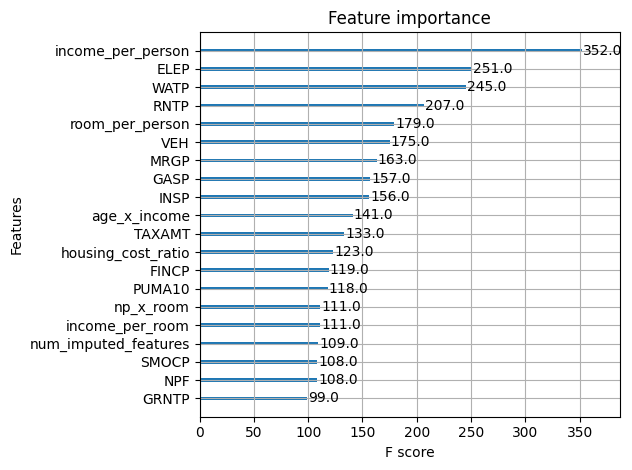

In [10]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(model, max_num_features=20)
plt.tight_layout()
plt.show()

## Exp

In [16]:
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier

# 1. Define full feature set again (in case you altered `X`)
excluded = ['FS', 'RT', 'SERIALNO', 'ADJINC', 'ADJHSG'] + [f'WGTP{i}' for i in range(1, 81)]
features = [col for col in df.columns if col not in excluded]
X = df[features]
y = df["FS"]

# 2. Instantiate base XGBoost model
xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    n_estimators=100,  # Use fewer trees for speed
    max_depth=4,
    learning_rate=0.1,
    verbosity=0,
    random_state=42
)

# 3. Run RFE
rfe = RFE(estimator=xgb_base, n_features_to_select=30, step=5)
rfe.fit(X, y)

# 4. Select top features
top_30_features = X.columns[rfe.support_]
X_rfe = X[top_30_features]

# 5. Train-test split on reduced features
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X_rfe, y, test_size=0.1, random_state=42
)

# 6. Train final model
final_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    random_state=42
)
final_model.fit(X_train, y_train)

# 7. Evaluate
from sklearn.metrics import classification_report
print(classification_report(y_test, final_model.predict(X_test)))


C:\Users\User\PycharmProjects\pums\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [23:40:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.93      0.98      0.95      6040
           1       0.69      0.36      0.47       703

    accuracy                           0.92      6743
   macro avg       0.81      0.67      0.71      6743
weighted avg       0.90      0.92      0.90      6743



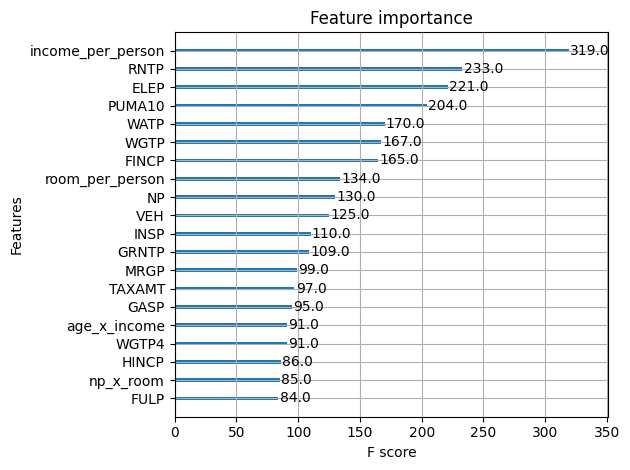

In [17]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(model, max_num_features=20)
plt.tight_layout()
plt.show()

In [11]:
# Define features, excluding FS (target), RT, SERIALNO, and WGTP
excluded = ['FS', 'RT', 'SERIALNO', 'ADJINC', 'ADJHSG'] + ['WGPT' + str(i) for i in range(1, 81, 1)]
features = [col for col in df.columns if col not in excluded]
X = df[features]
y = df["FS"]
sample_weights = df["WGTP"]

# Optional: remove rows with missing values
mask = y.notnull() & sample_weights.notnull()
X = X[mask]
y = y[mask]
sample_weights = sample_weights[mask]

# Step 2: Split data
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, sample_weights, stratify=y, test_size=0.2, random_state=42
)

# Step 3: Train with weights
model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

model.fit(X_train, y_train, sample_weight=w_train)
print(classification_report(y_test, model.predict(X_test)))

C:\Users\User\PycharmProjects\pums\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:48:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.93      0.98      0.95     12117
           1       0.67      0.33      0.44      1368

    accuracy                           0.92     13485
   macro avg       0.80      0.66      0.70     13485
weighted avg       0.90      0.92      0.90     13485



In [12]:
# Define features, excluding FS (target), RT, SERIALNO, and WGTP
excluded = ['FS', 'RT', 'SERIALNO', 'ADJINC', 'ADJHSG'] + ['WGPT' + str(i) for i in range(1, 81, 1)]
features = [col for col in df.columns if col not in excluded]
X = df[features]
y = df["FS"]
sample_weights = df["WGTP"]

# Optional: remove rows with missing values
mask = y.notnull() & sample_weights.notnull()
X = X[mask]
y = y[mask]
sample_weights = sample_weights[mask]

# Step 2: Split data
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, sample_weights, stratify=y, test_size=0.2, random_state=42
)

# Step 3: Train with weights
model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

model.fit(X_train, y_train, sample_weight=w_train)
print(classification_report(y_test, model.predict(X_test)))

C:\Users\User\PycharmProjects\pums\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:49:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.93      0.98      0.95     12117
           1       0.67      0.33      0.44      1368

    accuracy                           0.92     13485
   macro avg       0.80      0.66      0.70     13485
weighted avg       0.90      0.92      0.90     13485



In [13]:
# Define features, excluding FS (target), RT, SERIALNO, and WGTP
excluded = ['FS', 'RT', 'SERIALNO', 'ADJINC', 'ADJHSG'] + ['WGPT' + str(i) for i in range(1, 81, 1)]
features = [col for col in df.columns if col not in excluded]
X = df[features]
y = df["FS"]
weights = df["WGTP"]

# Compute imbalance ratio
pos = sum(y == 1)
neg = sum(y == 0)
scale = neg / pos
print(f"Class ratio: {neg}:{pos} => scale_pos_weight={scale:.2f}")

mask = y.notnull() & sample_weights.notnull()
X = X[mask]
y = y[mask]
sample_weights = sample_weights[mask]

# Split and train
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, sample_weights, stratify=y, test_size=0.2, random_state=42
)

model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    scale_pos_weight=scale,
    random_state=42
)

model.fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))

Class ratio: 60584:6838 => scale_pos_weight=8.86


C:\Users\User\PycharmProjects\pums\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:46:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.97      0.86      0.91     12117
           1       0.37      0.76      0.50      1368

    accuracy                           0.85     13485
   macro avg       0.67      0.81      0.71     13485
weighted avg       0.91      0.85      0.87     13485



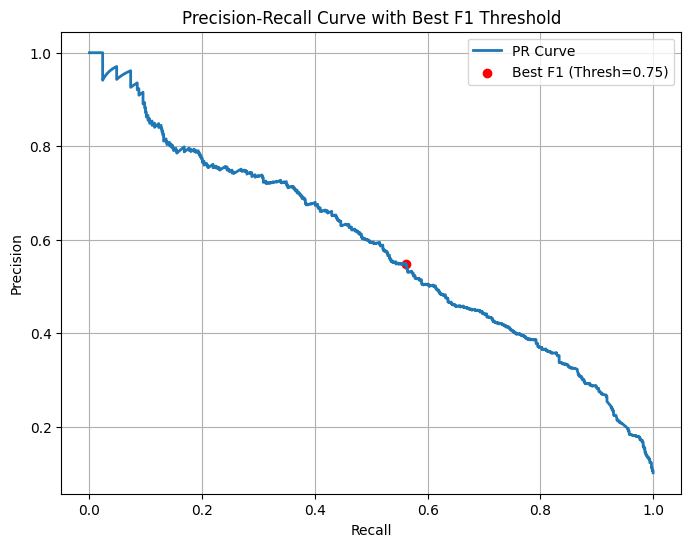

Best threshold: 0.75
F1 at best threshold: 0.555


In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score

# Get predicted probabilities (class 1 = received FS)
y_proba = model.predict_proba(X_test)[:, 1]

# Get precision-recall values for all thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Compute F1 scores for all thresholds
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

# Plot the PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="PR Curve", lw=2)
plt.scatter(recall[best_idx], precision[best_idx], color="red", label=f"Best F1 (Thresh={best_threshold:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve with Best F1 Threshold")
plt.legend()
plt.grid(True)
plt.show()

# Optionally print the best F1 threshold and value
print(f"Best threshold: {best_threshold:.2f}")
print(f"F1 at best threshold: {f1_scores[best_idx]:.3f}")
